In [48]:
!pip install dexplot

# Project - COVID-19 New Jersey Trends & Impact on RideSharing Platform

In [0]:
import pandas as pd
# import the seaborn module
import seaborn as sns
import matplotlib.pyplot as plt
import datetime  as dt
import numpy as np
from matplotlib.ticker import PercentFormatter
import os
import missingno as msno # visualize the distribution of NaN values
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import plotly
from datetime import datetime
import dexplot as dxp
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# import plotly.graph_objects
# from plotly.subplots import make_subplots

#### COVID-19 Dataset --> We have taken New Jersey covid19 data
source --> 
https://covidtracking.com/api/v1/states/daily.csv

#### X Dataset --> We are trying to observe the impact of COVID-19 on the stock prices of major Ridesharing Players (Uber + Lyft)
Source -->
https://finance.yahoo.com/quote/UBER/history?p=UBER

https://finance.yahoo.com/quote/LYFT/history?p=LYFT

Project Git Repository --> https://github.com/marif1901/COVID19_NJ_ImpactAnalysis

## Part 1: Data Pre Processing (10%)

In [0]:
cov_url= 'https://raw.githubusercontent.com/marif1901/COVID19_NJ_ImpactAnalysis/master/COVID19_NJ_Data.csv'
x_uber_url= "https://raw.githubusercontent.com/marif1901/COVID19_NJ_ImpactAnalysis/master/UBER_1Y.csv"
x_lyft_url= "https://raw.githubusercontent.com/marif1901/COVID19_NJ_ImpactAnalysis/master/LYFT_1Y.csv"


###### Reading Datasets

In [51]:
covid = pd.read_csv(cov_url,sep=',')# use sep="," for coma separation. 
xuber = pd.read_csv(x_uber_url,sep=',')
xlyft = pd.read_csv(x_lyft_url,sep=',')
print(covid.columns)
print(xuber.columns)
print(xlyft.columns)

Index(['date', 'state', 'positive', 'negative', 'pending',
       'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently',
       'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative',
       'recovered', 'dataQualityGrade', 'lastUpdateEt', 'hash', 'dateChecked',
       'death', 'hospitalized', 'total', 'totalTestResults', 'posNeg', 'fips',
       'deathIncrease', 'hospitalizedIncrease', 'negativeIncrease',
       'positiveIncrease', 'totalTestResultsIncrease', 'dailypositvecases',
       'dailynegativecases', 'dailytestingdone', 'dailydeath'],
      dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


###### Preprocessing on COVID Data

In [0]:
covid_cols= ['date','dailypositvecases','dailynegativecases','dailydeath','dailytestingdone',
             'positiveIncrease','negativeIncrease', 'deathIncrease','totalTestResultsIncrease',
            'positive', 'negative', 'death','totalTestResults']
covid_sel= covid[covid_cols].copy()

covid_cols= ['date','dailypositvecases','dailynegativecases','dailydeath','dailytestingdone',
             'positiveIncrease','negativeIncrease', 'deathIncrease','totalTestResultsIncrease',
            'cumpositive', 'cumnegative', 'cumdeath','cumtotalTestResults']

covid_sel.columns=  covid_cols

###### Dropping rows where data is NA

In [53]:
count_nulls= sum(pd.isna(covid_sel['date']))
print('\033[1m' + ' Total nulls found :' + str(count_nulls))
index = covid_sel[pd.isna(covid_sel['date'])].index
covid_sel.drop(index , inplace=True)

 Total nulls found :0


In [54]:
covid_sel.head(10)

,date,dailypositvecases,dailynegativecases,dailydeath,dailytestingdone,positiveIncrease,negativeIncrease,deathIncrease,totalTestResultsIncrease,cumpositive,cumnegative,cumdeath,cumtotalTestResults
0,20200507,68760,90580,4341,159340,1745,1993,252,3738,133635,159023,8801,292658
1,20200506,64875,68443,4460,133318,1297,0,305,1297,131890,157030,8549,288920
2,20200505,67015,88587,4089,155602,2324,8079,334,10403,130593,157030,8244,287623
3,20200504,63578,68443,4155,132021,1525,629,39,2154,128269,148951,7910,277220
4,20200503,64691,80508,3755,145199,3027,9727,129,12754,126744,148322,7871,275066
5,20200502,62053,67814,4116,129867,2527,3240,204,5767,123717,138595,7742,262312
6,20200501,61664,70781,3626,132445,2538,6089,310,8627,121190,135355,7538,256545
7,20200430,59526,64574,3912,124100,2388,4212,458,6600,118652,129266,7228,247918
8,20200429,59126,64692,3316,123818,2408,4551,328,6959,116264,125054,6770,241318
9,20200428,57138,60362,3454,117500,2668,3916,398,6584,113856,120503,6442,234359


###### Converting date to proper %Y%m%d format

In [0]:
covid_sel['date']= covid_sel['date'].astype(str)
covid_sel['date'] = pd.to_datetime(covid_sel['date'], format='%Y%m%d').dt.strftime("%Y-%m-%d");


In [56]:
int_col= ['dailypositvecases','dailynegativecases','dailydeath','dailytestingdone',
             'positiveIncrease','negativeIncrease', 'deathIncrease','totalTestResultsIncrease',
            'cumpositive', 'cumnegative', 'cumdeath','cumtotalTestResults']
#covid_sel[int_col] = covid_sel[int_col].convert_objects(convert_numeric=True)
covid_sel.dtypes

date                        object
dailypositvecases            int64
dailynegativecases           int64
dailydeath                   int64
dailytestingdone             int64
positiveIncrease             int64
negativeIncrease             int64
deathIncrease                int64
totalTestResultsIncrease     int64
cumpositive                  int64
cumnegative                  int64
cumdeath                     int64
cumtotalTestResults          int64
dtype: object

In [57]:
covid_sel.dtypes
covid_sel1=pd.DataFrame()
for k in list(covid_sel):
   covid_sel1[k]=pd.to_numeric(covid_sel[k], errors='ignore')
covid_sel1.dtypes

date                        object
dailypositvecases            int64
dailynegativecases           int64
dailydeath                   int64
dailytestingdone             int64
positiveIncrease             int64
negativeIncrease             int64
deathIncrease                int64
totalTestResultsIncrease     int64
cumpositive                  int64
cumnegative                  int64
cumdeath                     int64
cumtotalTestResults          int64
dtype: object

In [58]:
print('\033[1m' +'Min Date observed for COVID : ' + str(covid_sel['date'].min()))
print('\033[1m' + 'Max Date observed for COVID: ' + str(covid_sel['date'].max()))

Min Date observed for COVID : 2020-03-05
Max Date observed for COVID: 2020-05-07


###### Preprocessing on X Data

In [0]:
x_cols= ['Date','Close','Volume']

xuber_sel= xuber[x_cols].copy()
xlyft_sel= xlyft[x_cols].copy()

x_cols= ['date','UberClosingPrice','UberVolume']
xuber_sel.columns= x_cols

x_cols= ['date','LyftClosingPrice','LyftVolume']
xlyft_sel.columns=x_cols

In [0]:
xuber_sel.date= pd.to_datetime(xuber_sel['date']).dt.strftime('%Y-%m-%d')
xlyft_sel.date=pd.to_datetime(xlyft_sel['date']).dt.strftime('%Y-%m-%d')

In [61]:
x_sel= pd.merge(xuber_sel, xlyft_sel,on='date')
print('\033[1m' + 'Min Date observed for X : ' + str(x_sel['date'].min()))
print('\033[1m' + 'Max Date observed for X: ' + str(x_sel['date'].max()))

Min Date observed for X : 2019-05-10
Max Date observed for X: 2020-05-07


In [62]:
x_sel.head(10)

,date,UberClosingPrice,UberVolume,LyftClosingPrice,LyftVolume
0,2019-05-10,41.570000,186322500,51.090000,23111200
1,2019-05-13,37.099998,79442400,48.150002,10007400
2,2019-05-14,39.959999,46661100,50.520000,7007400
3,2019-05-15,41.290001,36086100,54.040001,7909300
4,2019-05-16,43.000000,38115500,55.599998,7101700
5,2019-05-17,41.910000,20225700,53.790001,4326500
6,2019-05-20,41.590000,29222300,54.630001,2710000
7,2019-05-21,41.500000,10802900,55.509998,3490700
8,2019-05-22,41.250000,9089500,57.880001,3913700
9,2019-05-23,40.470001,11119900,58.110001,3649300


In [63]:
x_sel.head()

,date,UberClosingPrice,UberVolume,LyftClosingPrice,LyftVolume
0,2019-05-10,41.570000,186322500,51.090000,23111200
1,2019-05-13,37.099998,79442400,48.150002,10007400
2,2019-05-14,39.959999,46661100,50.520000,7007400
3,2019-05-15,41.290001,36086100,54.040001,7909300
4,2019-05-16,43.000000,38115500,55.599998,7101700


###### Merging COVID data with X Data for Analysing impact in the same time frame

In [64]:
comb_df= covid_sel.merge(x_sel, how='inner', on='date')
comb_df=comb_df.drop_duplicates()
print('\033[1m' + 'Min Date observed for comb_df : ' + str(comb_df['date'].min()))
print('\033[1m' + 'Max Date observed for comb_df: ' + str(comb_df['date'].max()))

Min Date observed for comb_df : 2020-03-05
Max Date observed for comb_df: 2020-05-07


###### Filtering 8 weeks timeframe for Analysis, Starting Date from. Monday 9th March, End Date Sunday 3rd May

In [65]:
st_dt= pd.to_datetime('2020-03-09').strftime('%Y-%m-%d')
# print(st_dt)
end_dt= pd.to_datetime('2020-05-04').strftime('%Y-%m-%d')
# print(end_dt)

comb_df = comb_df[ (comb_df['date']>=st_dt) & (comb_df['date']<= end_dt)] 

print('\033[1m' + 'Min Date observed for comb_df : ' + str(comb_df['date'].min()))
print('\033[1m' + 'Max Date observed for comb_df: ' + str(comb_df['date'].max()))
print('\033[1m' + 'Total Rows * cols: ' + str(comb_df.shape))

comb_df.head(3)

Min Date observed for comb_df : 2020-03-09
Max Date observed for comb_df: 2020-05-04
Total Rows * cols: (40, 17)


,date,dailypositvecases,dailynegativecases,dailydeath,dailytestingdone,positiveIncrease,negativeIncrease,deathIncrease,totalTestResultsIncrease,cumpositive,cumnegative,cumdeath,cumtotalTestResults,UberClosingPrice,UberVolume,LyftClosingPrice,LyftVolume
3,2020-05-04,63578,68443,4155,132021,1525,629,39,2154,128269,148951,7910,277220,27.420000,23428300,27.030001,13393000
4,2020-05-01,61664,70781,3626,132445,2538,6089,310,8627,121190,135355,7538,256545,28.389999,19290200,29.605000,7339100
5,2020-04-30,59526,64574,3912,124100,2388,4212,458,6600,118652,129266,7228,247918,30.270000,20095400,32.830002,4624500


###### Assigning Week Number

In [0]:
comb_df['WeekNum'] = ((pd.to_datetime(comb_df['date']) - pd.to_datetime(st_dt)).dt.days)//7 +1
# weeklycount=comb_df['WeekNum'].value_counts()
# weeklycount

###### Checking Nullity and Data Completeness

Text(0.5, 1.0, 'Data Completenss Check for Combined data')

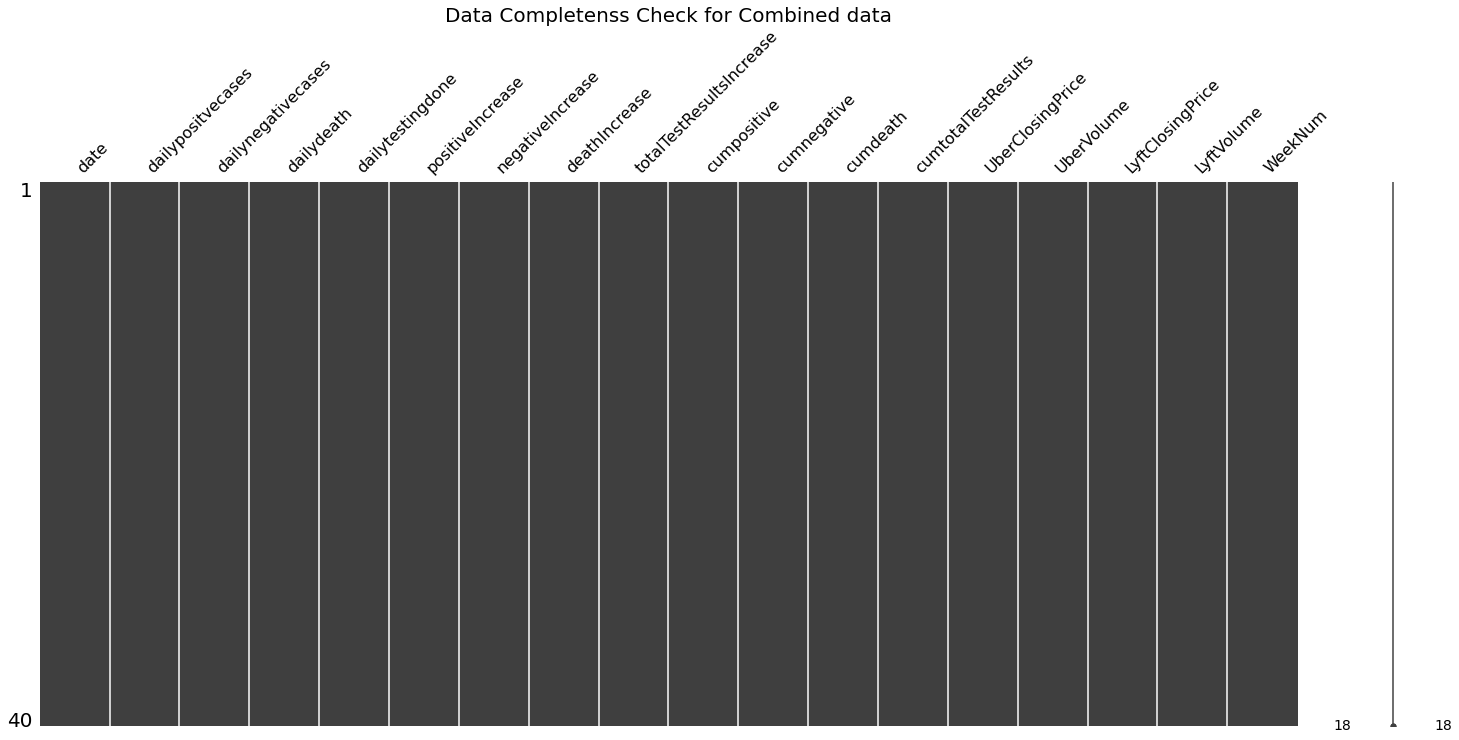

In [67]:
msno.matrix(comb_df)
plt.title('Data Completenss Check for Combined data', size = 20)

###### No Nullity found above

comb_df is the master data set that is preserved through out the exercise for analysis

In [0]:
comb_df= comb_df.sort_values(by="date")
print(comb_df.shape)

(40, 18)


## Part 2: General Trends in Covid + X Data (10%)

###### Day on Day Trends | PDF  | CDF of COVID 19 Growth

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['dailypositvecases'], 
                         mode='lines+markers', name='Confirmed'))
fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['dailydeath'], 
                         mode='lines+markers', name='Deaths'))
fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['dailynegativecases'], 
                         mode='lines+markers', name='Negative'))

fig.update_layout(
        xaxis_title="",
        yaxis_title="",
        title = '[Daily Cases] - Confirmed, Deaths & Negative'
#         yaxis_type="log"
    )
fig.show()

###### Let's check the distribution of data for Confirmed Cases, Negative Cases and Deaths

Text(0.5, 0.98, 'Distribution of Day on Day in Confirmed Cases | Negative Cases & Deaths')

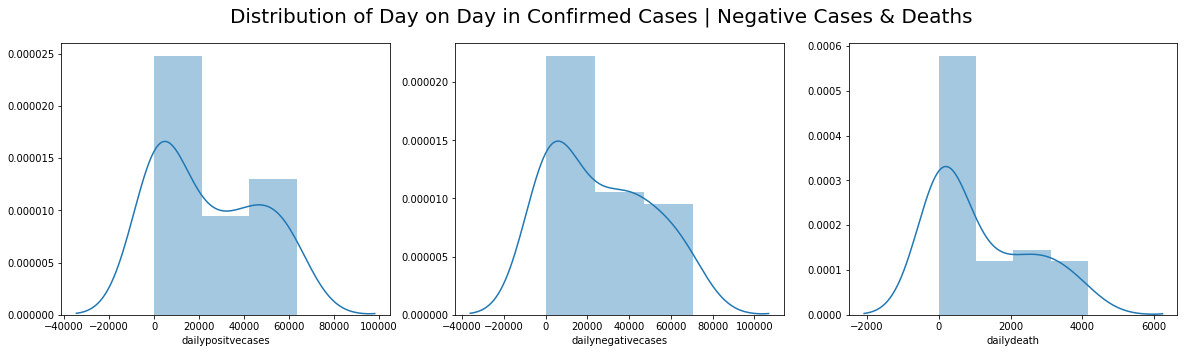

In [0]:
#histogram
fig = plt.figure(figsize= (20,5))
plt.subplot(1,3,1)
sns.distplot(comb_df['dailypositvecases'])

plt.subplot(1,3,2)
sns.distplot(comb_df['dailynegativecases'])

plt.subplot(1,3,3)
sns.distplot(comb_df['dailydeath'])

fig.suptitle("Distribution of Day on Day in Confirmed Cases | Negative Cases & Deaths", fontsize=20)


###### Inference from above graph: we can clearly see that for confirmed and positive cases it follows a smooth curve with fluctuations while death is mostly uniform after certain number of days so its flat in nature 

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['cumpositive'], 
                         mode='lines+markers', name='Confirmed'))
fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['cumdeath'], 
                         mode='lines+markers', name='Deaths'))
fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['cumnegative'], 
                         mode='lines+markers', name='Negative'))

fig.update_layout(
        xaxis_title="",
        yaxis_title="",
#         title = 'Cumulative -> Confirmed, Deaths & Negative Results'
        title = 'CDF [Log Scale]-> Confirmed, Deaths & Negative Results',
        yaxis_type="log"
    )
fig.show()

###### Inference from above graph: It can be observed there was a steep increase in the confirm cases from Mar9 to Apr6 since then the rate of increase seems to be decreasing and curve looks to be flattening after Apr20 while death is observed to be increasing at constant pace

In [0]:
df_t= comb_df.copy()
df_t['Positive Rate'] = df_t['cumpositive']/df_t['cumtotalTestResults']
df_t['Negative Rate'] = df_t['cumnegative']/df_t['cumtotalTestResults']

df_t['Death Rate'] = df_t['cumdeath']/df_t['cumpositive']



fig = go.Figure()
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['Positive Rate'], 
                         mode='lines+markers', name='Positive Rate'))
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['Negative Rate'], 
                         mode='lines+markers', name='Negative Rate'))
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['Death Rate'], 
                         mode='lines+markers', name='Death Rate'))
fig.update_layout(
        xaxis_title="",
        yaxis_title="",
        title = 'Confirmed Rate, Negative Rate & Death Rate'
#         yaxis_type="log"
    )
fig.show()


###### Inference from above graph: This is interesting that in the intial few days of the outbreak there are mostly postive cases, this is due to testing being limited to high potential people whle we can see that with time testing has picked up and negative and positive cases seems to be breaking even in the current scenario and negative cases are more after the complete lockdown, while death rate seems to be gently increasing 

In [0]:
## Sketch Pre period also for this
lockdown_dt= pd.to_datetime('2020-03-18').strftime('%Y-%m-%d')
x_sel['Period']= np.where(x_sel['date'] >= lockdown_dt, 'PostLockdown', 'PreLockdown')

x_sel['UberTradedStocks']= x_sel['UberVolume']* x_sel['UberClosingPrice']
x_sel['LyftTradedStocks']= x_sel['LyftVolume'] * x_sel['LyftClosingPrice']


Text(0.5, 0.98, 'Day on Day #Traded Stockcs  of Uber | Lyft Pre v/s Post Lockdown Period')

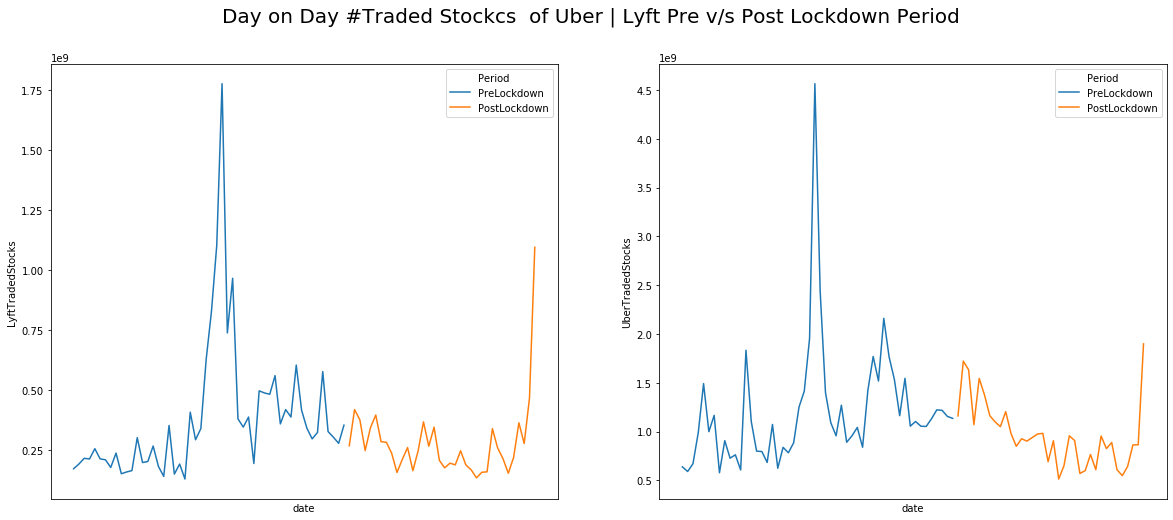

In [0]:
time_eda= pd.to_datetime('2020-01-01').strftime('%Y-%m-%d')
x_tmp= x_sel.copy()
x_tmp = x_tmp[x_tmp['date']>=time_eda] 

fig = plt.figure(figsize= (20,8))
plt.subplot(1,2,1)

g =sns.lineplot(x="date", y="LyftTradedStocks",
              hue="Period",
              data=x_tmp)
g.set(xticks=[])

plt.subplot(1,2,2)
g =sns.lineplot(x="date", y="UberTradedStocks",
              hue="Period",
              data=x_tmp)
g.set(xticks=[])
fig.suptitle("Day on Day #Traded Stockcs  of Uber | Lyft Pre v/s Post Lockdown Period", fontsize=20)


###### Inference from above graph: We can clearly see that COVID19 outbreak has very badly hit ride sharing market, traded stocks have gone down by very high rate, can be seen from the pre v/s post lockdown period 

In [0]:
df_temp= comb_df.copy()
df_temp['Uber_pctChange'] = df_temp['UberClosingPrice'].pct_change(periods=1)
df_temp['Lyft_pctChange'] = df_temp['LyftClosingPrice'].pct_change(periods=1)
df_temp['Confirmed_pctChange'] = df_temp['cumpositive'].pct_change(periods=1)
df_temp = df_temp.iloc[1:]
# df_temp.head()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_temp['date'], y=df_temp['Confirmed_pctChange'], 
                         mode='lines+markers', name='Confirmed_pctChange'))

fig.add_trace(go.Scatter(x=df_temp['date'], y=df_temp['Uber_pctChange'], 
                         mode='lines+markers', name='Uber_pctChange'))

fig.add_trace(go.Scatter(x=df_temp['date'], y=df_temp['Lyft_pctChange'], 
                         mode='lines+markers', name='Lyft_pctChange'))

fig.update_layout(
        xaxis_title="",
        yaxis_title="",
        title = 'Velocity of -> Confirmed Cases , LyftClosingPrice & UberClosingPrice'
#         title = 'CDF [Log Scale]-> Confirmed, Deaths & Negative Results',
#         yaxis_type="log"
    )
fig.show()

Text(0.5, 0.98, 'Histogram of Precentage Change Day on Day in Stock Prices of Uber | Lyft & Confirmed Cases')

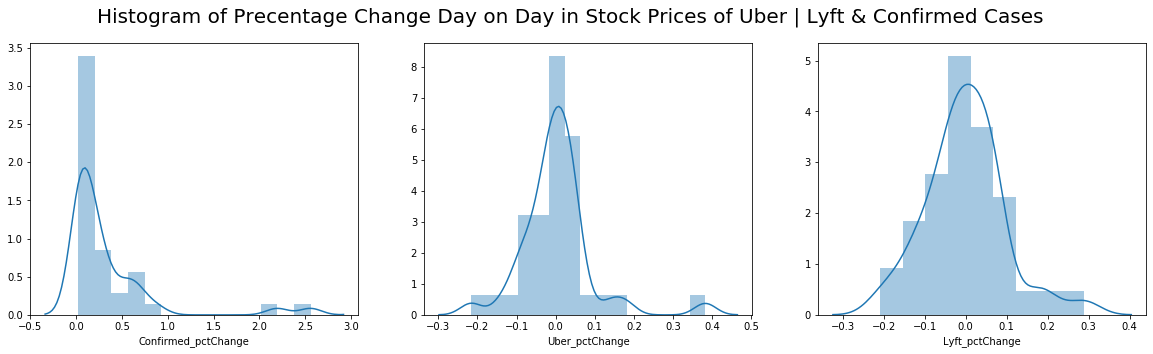

In [0]:
#histogram
fig = plt.figure(figsize= (20,5))
plt.subplot(1,3,1)
sns.distplot((df_temp['Confirmed_pctChange']))

plt.subplot(1,3,2)
sns.distplot(df_temp['Uber_pctChange'], label="Uber Changes")

plt.subplot(1,3,3)
sns.distplot((df_temp['Lyft_pctChange']))


# plt.title('Distribution of scores assigned to every house',size= 20)
fig.suptitle("Histogram of Precentage Change Day on Day in Stock Prices of Uber | Lyft & Confirmed Cases", fontsize=20)



###### Inference from above graph: As the velocity in the Positive Cases increases we see that velocity in the Uber & Lyft Price decreases and when the velocity of confirm cases decreases then velocity in the Stock Prices of Uber Lyft Increases,
###### Changes in the confirmed cases is right skewed which suggests increasing cases while for Uber & Lyft we see that its left skewed which shows a constant decline in this Stock Prices while Lyft has smooth fluctuation

In [0]:
df_temp=comb_df.copy()
df_temp['Country_Region']= 'NJ'
df_temp['Lat']= 39.833851
df_temp['Long']= -74.871826

df_temp = df_temp.groupby(['date', 'Country_Region','Lat','Long'])['cumpositive', 'cumdeath'].max().reset_index()
df_temp["date"] = pd.to_datetime(df_temp["date"]).dt.strftime('%m/%d/%Y')
df_temp.columns=['Last_Update','Country_Region','Lat','Long','Confirmed','Deaths']
df_temp['Confirmed'].fillna(0, inplace=True)
df_temp.sort_values('Confirmed', ascending=False).head()

,Last_Update,Country_Region,Lat,Long,Confirmed,Deaths
39,05/04/2020,NJ,39.833851,-74.871826,128269,7910
38,05/01/2020,NJ,39.833851,-74.871826,121190,7538
37,04/30/2020,NJ,39.833851,-74.871826,118652,7228
36,04/29/2020,NJ,39.833851,-74.871826,116264,6770
35,04/28/2020,NJ,39.833851,-74.871826,113856,6442


In [0]:
fig = px.scatter_geo(df_temp,
                     #locations="Country_Region",
                     locationmode='country names',
                     lat='Lat', lon='Long',
                     #hover_name="Country_Region",
                     hover_data=["Confirmed", "Deaths"], animation_frame="Last_Update",
                     color=np.log10(df_temp["Confirmed"]+1)-1, size=np.power(df_temp["Confirmed"]+1, 0.3)-1,
                     range_color= [0, max(np.log10(df_temp["Confirmed"]+1))],
                     title="COVID-19 Progression Animation Over Time",
                     color_continuous_scale=px.colors.sequential.Plasma,
                     projection="natural earth"
                    )
fig.update_coloraxes(colorscale="hot")
fig.update(layout_coloraxis_showscale=False)
#fig.update_coloraxes(colorbar_title="Color (Confirmed Cases Log Scale)")
fig.show()

In [0]:
fig = px.choropleth(df_temp,
                    locations="Country_Region",
                    locationmode="USA-states",
                    #lat='Lat', lon='Long',
                    hover_name="Country_Region",
                    hover_data=["Confirmed", "Deaths"], animation_frame="Last_Update",
                    color=np.log10(df_temp["Confirmed"]), 
                     
                    title="COVID-19 Progression Animation in New Jersey Over Time",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    scope="usa",
                   )
fig.update(layout_coloraxis_showscale=False)
fig.show()


## Part 3: Required Inferences (50%)

### 3.1 Predicting the COVID19 fatality & #cases over next one week

Use your COVID19 dataset to predict the COVID19 fatality and #cases for the next one week. Use the following four prediction techniques: (i) AR(3), (ii) AR(5), (iii) EWMA with alpha = 0.5, and (iv) EWMA with alpha = 0.8. Make sure that your dataset allows you to verify the one week prediction. For example, use the first three weeks of data to predict the fourth week, and report the accuracy of your predictions using the actual fourth week data. Use metrics learned in class (MAPE as a % and MSE) to report accuracy numbers.

#### 3.1.1 AR(3)

#### 3.1.2 AR(5)

#### 3.1.3 EWMA with alpha = 0.5

#### 3.1.4 EWMA with alpha = 0.8

### 3.2 Apply the Wald’s test, Z-test, and t-test to check whether the mean of COVID19 deaths and #cases are different from the first week to the last week

Apply the Wald’s test, Z-test, and t-test (assume all are applicable) to check whether the mean of COVID19 deaths and #cases are different from the first week to the last week in your dataset. Use MLE for Wald’s test as the estimator. Note, you have to report results for deaths and #cases separately, so think of this as two inferences. After running the test and reporting the numbers, check and comment on whether the tests are applicable or not. First use one-sample tests by computing the mean of the first week data and using that as guess for last week data. Then, repeat with a two-sample version of Wald and t-tests. For t-test, use both paired and unpaired tests. Use alpha value of 0.05 for all. For t-test, the threshold to check against is tn-1, alpha/2 for two-tailed and tn-1, alpha for one-tailed, where n is the number of data points. You can find these values in online t tables, similar to z tables.

#### 3.2.1 Use MLE for Wald’s test as the estimator

#### 3.2.2 Two-sample version of Wald and t-tests

#### 3.2.3 Z-test

### 3.3 Equality of distributions [ distribution of 2nd last week and last week ], using K-S test and Permutation test

#### 3.3.1 K-S Test

Equality of distributions (distribution of first week and last week), using K-S test and Permutation test. For the K-S test, use both 1-sample and 2-sample tests. For the 1-sample test, try Poisson, Geometric, and Binomial. To obtain parameters of these distributions to check against in 1-sample KS, use MME on first week’s data to obtain parameters of the distribution, and then check whether the last week’s data has the distribution with the obtained MME parameters. Use a threshold of 0.05 for both K-S test and Permutation test.

##### Data set required for KS test and Permutation test

In [194]:
covid_sel.head()

,date,dailypositvecases,dailynegativecases,dailydeath,dailytestingdone,positiveIncrease,negativeIncrease,deathIncrease,totalTestResultsIncrease,cumpositive,cumnegative,cumdeath,cumtotalTestResults
0,2020-05-07,68760,90580,4341,159340,1745,1993,252,3738,133635,159023,8801,292658
1,2020-05-06,64875,68443,4460,133318,1297,0,305,1297,131890,157030,8549,288920
2,2020-05-05,67015,88587,4089,155602,2324,8079,334,10403,130593,157030,8244,287623
3,2020-05-04,63578,68443,4155,132021,1525,629,39,2154,128269,148951,7910,277220
4,2020-05-03,64691,80508,3755,145199,3027,9727,129,12754,126744,148322,7871,275066


In [0]:
##copy of dataset
dataset=covid_sel
#print(dataset.head(1))
#print(dataset.shape)



secondlastWeek=dataset.iloc[ 0:7, : ]
lastWeek=dataset.iloc[7:14, :]
#print(secondlastWeek.head(7))
#print(lastWeek.head(7))

secondlastWeek_cases=list(secondlastWeek['dailypositvecases'].to_numpy())
lastWeek_cases=list(lastWeek['dailypositvecases'].to_numpy())

secondlastWeek_testcases=list(secondlastWeek['dailytestingdone'].to_numpy())
lastWeek_testcases=list(lastWeek['dailytestingdone'].to_numpy())

secondlastWeek_deaths=list(secondlastWeek['dailydeath'].to_numpy())
lastWeek_deaths=list(lastWeek['dailydeath'].to_numpy())


In [0]:
def draw_plot(sample1,Fy, week1,dataText):
  #week1, week2,dataText=1,2,"text"
  
  
  print("Sample1:",sample1)
  n1 = len(sample1)
  Sorted1 = sorted(sample1)
  delta = 1
  X1 = [min(Sorted1)-delta]
  Y1 = [0]
  for i in range(0,n1):
    X1 = X1 + [Sorted1[i], Sorted1[i]]
    Y1 = Y1 + [Y1[len(Y1)-1], Y1[len(Y1)-1]+(1/n1)]
  X1 = X1 + [max(Sorted1)+delta]
  Y1 = Y1 + [1]
  #print(X1,Y1)
  
  delta2=20
  X2= [min(sample1) - delta2 ] + sample1 + [max(sample1) +delta2]
  Y2= [0]  + Fy + [1]
  fig = plt.figure('eCDF', figsize=(10,10))
  # plt.figure()
  plt.plot(X1, Y1 ,color='blue',label='eCDF for distribution of data for all  in '+ week1)
  plt.plot(X2, Y2 ,color='green',label='CDF for distribution of data for all  in '+ week1)

  plt.xlabel('x')
  plt.ylabel('Pr[X<=x]')
  plt.title('eCDF of Distribution of DataPoints '+ dataText)
  plt.legend(loc="upper left")
  plt.grid()
  plt.show()



#### Poisson distribution KS test


>For Number of Deaths:  

>> **Null Hypothesis:** CDF Distribution of data for Number of Deaths is equivalent to the CDF of Poisson Distribution



>For Number of Cases:   

>> **Null Hypothesis:** CDF Distribution of data for Number of Cases is equivalent to the CDF of Poisson Distribution


Here we check if the data follows Poisson Distribution


#### Poisson Distribution : Number of deaths

In [190]:
#Poisson distribution requires lambda -> MME for second last
## guess lambda for last week
from scipy.special import factorial
from matplotlib import pyplot as plt

from scipy.stats import poisson
import matplotlib.pyplot as plt

lambda_mme_deaths =  np.mean(secondlastWeek_deaths)
lambda_mle_deaths =  np.mean(secondlastWeek_deaths)


lambda_mme_cases = np.mean(secondlastWeek_cases)
lambda_mle_cases = np.mean(secondlastWeek_cases)

print("MME Poisson distribution for the number of deaths Lambda",lambda_mme_deaths)

##Cdf of Poisson distribution

def poisson_cdf(x, mu,elambda):
  summ=0
  for i in range(x):
    lambda_i= mu ** i
    fact_i=factorial(i)
    summ+=  (lambda_i * fact_i)

  return (elambda * summ)

##First Column of the KS Test
def cdf_poisson(x_dataset, lambda_):
  array_poisson=[]
  e=2.718
  e_lambda= e ** (-lambda_)
  
  for i in range(len(x_dataset)):
      if e_lambda:
        datapoint=poisson_cdf(x_dataset[i], lambda_,e_lambda)
      else:
        datapoint=0
      array_poisson.append(datapoint)
  return array_poisson

##2nd  Column of the KS Test
def Fx_negX(factor):
  result=[0,round(factor,2)]
  i,summ=2,factor
  while i < 7:
    summ=round(i * factor,2)
    i+=1
    result.append(summ)

  return result

##3rd Column of the KS Test
def Fx_posX(factor):
  result=[round(factor,2)]
  i, summ=2,factor
  while i <= 7:
    summ=round(i * factor,2)
    i+=1
    result.append(summ)

  return result
#######################################
##deaths


factor=(1/len(lastWeek_deaths))
print("Data for last week",lastWeek_deaths)

F_y=cdf_poisson(sorted(lastWeek_deaths),lambda_mme_deaths) ##Fy_x
print("F_y -> 2nd Column of the KS Test",F_y)
Fx_neg=Fx_negX(factor)
print("Fx_neg -> 4th Column of the KS Test",Fx_neg)

Fx_pos=Fx_posX(factor)
print("Fx_pos -> 5th Column of the KS Test",Fx_pos)

Fxpos_diff_Fy= [Fx_pos[j] - F_y[j] for j in range(len(Fx_pos)) ] 
print("Fxpos_diff_Fy -> 6th Column of the KS Test",Fxpos_diff_Fy)

Fxneg_diff_Fy=[Fx_neg[j] - F_y[j] for j in range(len(Fx_neg)) ] 
print("Fxneg_diff_Fy -> 7th Column of the KS Test ",Fxneg_diff_Fy)



D__FxFy=(Fxpos_diff_Fy) +(Fxneg_diff_Fy)

D=max(D__FxFy)
print("Maximum values found D(Fx,Fy):",D)

if D < 0.05:
  print("We accept the KS test for 1-sample test: Daily death data vs Poisson Distribution ")
else:
  print("We reject the KS test for 1-sample test: Daily death data vs Poisson Distribution ")

print()

draw_plot(sorted(lastWeek_deaths),F_y, "Last Week", " Number of Deaths")



MME Poisson distribution for the number of deaths Lambda 4077.4285714285716
Data for last week [3912, 3316, 3454, 2988, 3056, 2882, 2981]
F_y -> 2nd Column of the KS Test [0, 0, 0, 0, 0, 0, 0]
Fx_neg -> 4th Column of the KS Test [0, 0.14, 0.29, 0.43, 0.57, 0.71, 0.86]
Fx_pos -> 5th Column of the KS Test [0.14, 0.29, 0.43, 0.57, 0.71, 0.86, 1.0]
Fxpos_diff_Fy -> 6th Column of the KS Test [0.14, 0.29, 0.43, 0.57, 0.71, 0.86, 1.0]
Fxneg_diff_Fy -> 7th Column of the KS Test  [0, 0.14, 0.29, 0.43, 0.57, 0.71, 0.86]
Maximum values found D(Fx,Fy): 1.0
We reject the KS test for 1-sample test: Daily death data vs Poisson Distribution 



TypeError: ignored

#### Poisson Distribution : Number of cases

MME Poisson distribution for the number of cases Lambda 64662.28571428572
F_y -> 2nd Column of the KS Test [0, 0, 0, 0, 0, 0, 0]
F_y -> 3rd Column of the KS Test [0, 0.14, 0.29, 0.43, 0.57, 0.71, 0.86]
Fx_pos -> 4th Column of the KS Test [0.14, 0.29, 0.43, 0.57, 0.71, 0.86, 1.0]
5th Column of the KS Test [0.14, 0.29, 0.43, 0.57, 0.71, 0.86, 1.0]
6th Column of the KS Test [0, 0.14, 0.29, 0.43, 0.57, 0.71, 0.86]
Maximum values found D(Fx,Fy): 1.0
We reject the KS test for 1-sample test: Daily cases data vs Poisson Distribution 
Sample1: [50955, 54470, 54568, 56718, 57138, 59126, 59526]


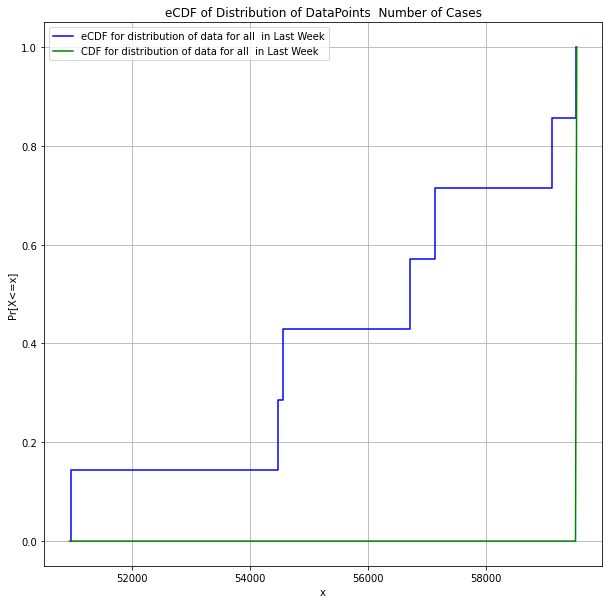

In [200]:
#######################################
print("MME Poisson distribution for the number of cases Lambda",lambda_mme_cases)

##cases
factor=(1/len(lastWeek_cases))

F_y=cdf_poisson(lastWeek_cases,lambda_mme_cases) ##Fy_x
print("F_y -> 2nd Column of the KS Test", F_y)
Fx_neg=Fx_negX(factor)
print("F_y -> 3rd Column of the KS Test",Fx_neg)

Fx_pos=Fx_posX(factor)
print("Fx_pos -> 4th Column of the KS Test",Fx_pos)

Fxpos_diff_Fy= [Fx_pos[j] - F_y[j] for j in range(len(Fx_pos)) ] 
print("5th Column of the KS Test",Fxpos_diff_Fy)

Fxneg_diff_Fy=[Fx_neg[j] - F_y[j] for j in range(len(Fx_neg)) ] 
print("6th Column of the KS Test",Fxneg_diff_Fy)



D__FxFy=(Fxpos_diff_Fy) +(Fxneg_diff_Fy)

D=max(D__FxFy)
print("Maximum values found D(Fx,Fy):",D)

if D < 0.05:
  print("We accept the KS test for 1-sample test: Daily cases data vs Poisson Distribution ")
else:
  print("We reject the KS test for 1-sample test: Daily cases data vs Poisson Distribution ")

draw_plot(sorted(lastWeek_cases),F_y, "Last Week", " Number of Cases")


#### Conclusion
>For Number of Deaths:  

>> **Null Hypothesis:**  CDF Distribution of data for Number of Deaths is equivalent to the CDF of Poisson Distribution
 
>> **We reject this Hypothesis.**


>**For Number of Cases: **  

>> **Null Hypothesis**:  CDF Distribution of data for Number of Cases is equivalent to the CDF of Poisson Distribution

>> **We reject this Hypothesis.**

> Hence,Given data does not follow the Poisson Distribution


#### Geometric Distribution

#### 1-Sample KS test with Geometric Distribution 

>For Number of Deaths:  

>> **Null Hypothesis:**  CDF Distribution of data for Number of Deaths is equivalent to the CDF of Geometric Distribution
 


>For Number of Cases:   

>> **Null Hypothesis:**  CDF Distribution of data for Number of Cases is equivalent to the CDF of Geometric Distribution

Here we check if the data follows Geometric Distribution



#### Geometric Distribution : Number of deaths





Geometric Mean p 0.00024525261018849414 1.5464965225921047e-05
Fy 2nd Column of the KS Test [0.5068316641634153, 0.5186630322423791, 0.5194887685358018, 0.5274368542589483, 0.5566329951259683, 0.5713893764546285, 0.6169331957696513]
F -x 3rd Column of the KS Test [0, 0.14, 0.29, 0.43, 0.57, 0.71, 0.86]
F +x 4th Column of the KS Test [0.14, 0.29, 0.43, 0.57, 0.71, 0.86, 1.0]
F+x - Fy 5th Column of the KS Test [0.3668316641634153, 0.2286630322423791, 0.08948876853580184, 0.04256314574105169, 0.15336700487403165, 0.2886106235453715, 0.38306680423034867]
F-x - Fy 6th Column of the KS Test [0.5068316641634153, 0.37866303224237907, 0.22948876853580186, 0.09743685425894827, 0.01336700487403164, 0.13861062354537146, 0.24306680423034865]
Maximum values found D(Fx,Fy): 0.5068316641634153
We reject the KS test for 1-sample test: Daily deaths data vs Geometric Distribution 
Sample1: [2882, 2981, 2988, 3056, 3316, 3454, 3912]


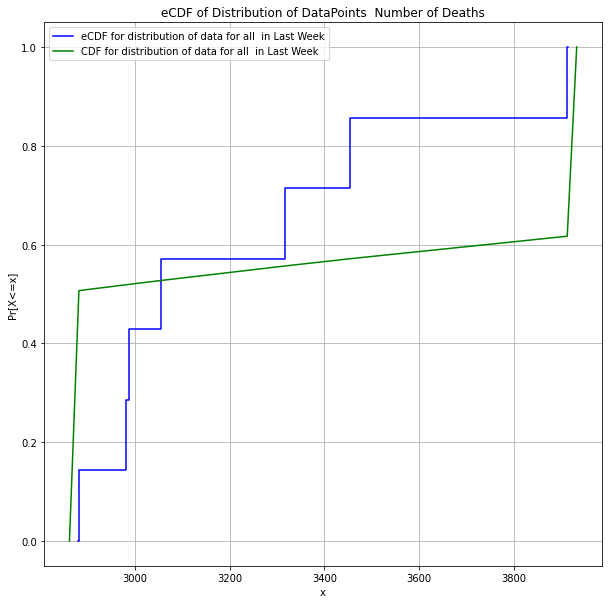

In [198]:
#Geometric distribution requires p -> MME for 3 part of data
## guess lambda for last week
from scipy.special import factorial
from scipy.stats import geom

p_mme_deaths =  1/np.mean(secondlastWeek_deaths)
p_mle_deaths =  1/np.mean(secondlastWeek_deaths)


p_mme_cases = 1/np.mean(secondlastWeek_cases)
p_mle_cases = 1/np.mean(secondlastWeek_cases)

print("Geometric Mean p",p_mme_deaths,p_mme_cases)

##Pdf of Geometric distribution

def cdf_geometric(x_dataset, prob):
  array_geom=[]
  for k in range(len(x_dataset)):
    element= (1 - ((1 - prob)** x_dataset[k]))
    array_geom.append(element)
  return array_geom

def pmf_geometric(x_dataset, prob):
  array_geom=[]
  element=0
  for k in range(len(x_dataset)):
    element+= geom.pmf(x_dataset[k], prob)
    array_geom.append(element)
  return array_geom


##deaths
factor=float(1/len(lastWeek_deaths))
F_y=cdf_geometric(sorted(lastWeek_deaths),p_mme_deaths) ##Fy_x
print("Fy 2nd Column of the KS Test",F_y)
Fx_neg=Fx_negX(factor)
print("F -x 3rd Column of the KS Test",Fx_neg)

Fx_pos=Fx_posX(factor)
print("F +x 4th Column of the KS Test",Fx_pos)

Fxpos_diff_Fy= [abs(Fx_pos[j] - F_y[j]) for j in range(len(Fx_pos)) ] 
print("F+x - Fy 5th Column of the KS Test",Fxpos_diff_Fy)

Fxneg_diff_Fy=[abs(Fx_neg[j] - F_y[j]) for j in range(len(Fx_neg)) ] 
print("F-x - Fy 6th Column of the KS Test",Fxneg_diff_Fy)



D__FxFy=(Fxpos_diff_Fy) +(Fxneg_diff_Fy)

D=max(D__FxFy)
print("Maximum values found D(Fx,Fy):",D)

if D < 0.05:
  print("We accept the KS test for 1-sample test: Daily deaths data vs Geometric Distribution ")
else:
  print("We reject the KS test for 1-sample test: Daily deaths data vs Geometric Distribution ")

draw_plot(sorted(lastWeek_deaths),(F_y), "Last Week", " Number of Deaths")




#### Geometric Distribution : Number of cases


Fy 2nd Column of the KS Test [0.5452572463373957, 0.5693170909854821, 0.5699693302767472, 0.5840327219054895, 0.586725813249314, 0.5992384249588678, 0.6017098974697579]
F -x 3rd Column of the KS Test [0, 0.14, 0.29, 0.43, 0.57, 0.71, 0.86]
F +x 4th Column of the KS Test [0.14, 0.29, 0.43, 0.57, 0.71, 0.86, 1.0]
F+x - Fy 5th Column of the KS Test [0.4052572463373957, 0.27931709098548213, 0.13996933027674724, 0.014032721905489542, 0.12327418675068591, 0.2607615750411322, 0.3982901025302421]
F-x - Fy 6th Column of the KS Test [0.5452572463373957, 0.4293170909854821, 0.27996933027674725, 0.1540327219054895, 0.016725813249314103, 0.11076157504113215, 0.2582901025302421]
Maximum values found D(Fx,Fy): 0.5452572463373957
We reject the KS test for 1-sample test: Daily cases data vs Geometric Distribution 
Sample1: [2882, 2981, 2988, 3056, 3316, 3454, 3912]


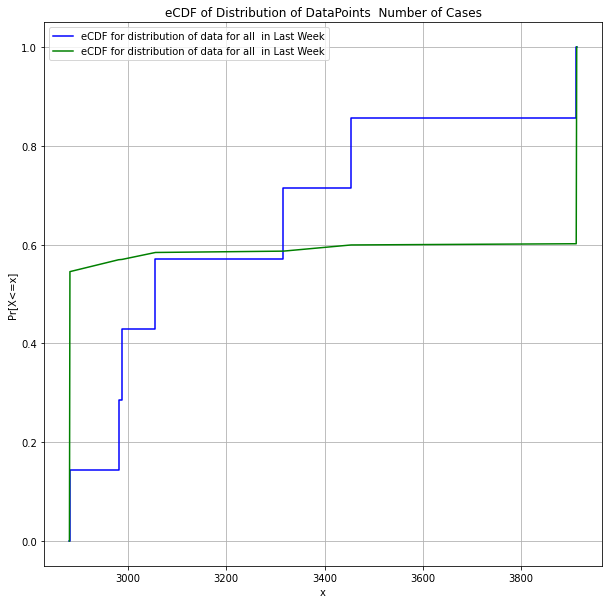

In [148]:
########################################


##cases
factor=float(1/len(lastWeek_cases))

F_y=cdf_geometric(sorted(lastWeek_cases),p_mme_cases) ##Fy_x
print("Fy 2nd Column of the KS Test",F_y)
Fx_neg=Fx_negX(factor)
print("F -x 3rd Column of the KS Test",Fx_neg)

Fx_pos=Fx_posX(factor)
print("F +x 4th Column of the KS Test",Fx_pos)

Fxpos_diff_Fy= [abs(Fx_pos[j] - F_y[j]) for j in range(len(Fx_pos)) ] 
print("F+x - Fy 5th Column of the KS Test",Fxpos_diff_Fy)

Fxneg_diff_Fy=[abs(Fx_neg[j] - F_y[j]) for j in range(len(Fx_neg)) ] 
print("F-x - Fy 6th Column of the KS Test",Fxneg_diff_Fy)



D__FxFy=(Fxpos_diff_Fy) +(Fxneg_diff_Fy)

D=max(D__FxFy)
print("Maximum values found D(Fx,Fy):",D)

if D < 0.05:
  print("We accept the KS test for 1-sample test: Daily cases data vs Geometric Distribution ")
else:
  print("We reject the KS test for 1-sample test: Daily cases data vs Geometric Distribution ")

draw_plot(sorted(lastWeek_deaths),(F_y), "Last Week", " Number of Cases")


#### Conclusion
>For Number of Deaths:  

>> **Null Hypothesis:**  CDF Distribution of data for Number of Deaths is equivalent to the CDF of Geometric Distribution
 
>> **We reject this Hypothesis.**


>For Number of Cases:   

>> **Null Hypothesis:**  CDF Distribution of data for Number of Cases is equivalent to the CDF of Geometric Distribution

>> **We reject this Hypothesis.**

> Hence,Given data does not follow the Geometric Distribution


 #### Binomial Distribution

#### KS test for Binomial Distribution

>For Number of Deaths:  

>> Null Hypothesis:  CDF Distribution of data for Number of Deaths is equivalent to the CDF Binomial Distribution
 


>For Number of Cases:   

>> Null Hypothesis:  CDF Distribution of data for Number of Cases is equivalent to the CDF Binomial Distribution

Here we check if the data follows Binomial Distribution

MME for parameter p(probability) is calculated using the 2nd last week's data.
>For Number of Deaths:  
 n -> Number of trails (Number of positive cases)  
 k -> Number of successes ( Number of Deaths)   

>For Number of Cases:   
 n -> Number of trails (Number of total cases).  
 k -> Number of successes ( Number of positive cases). 




#### Binomial Distribution : Number of deaths

x [68760, 64875, 67015, 63578, 64691, 62053, 61664]
F +x [0.14, 0.29, 0.43, 0.57, 0.71, 0.86, 1.0]
F -x [0, 0.14, 0.29, 0.43, 0.57, 0.71, 0.86]
Deaths Binomial MME p: 0.0630572910683198
F_y  [0.0, 0.0, 0.0, 0.0, 0.0, 4.257910351665494e-268, 3.121736395293333e-47]
F+x - Fy [0.14, 0.29, 0.43, 0.57, 0.71, 0.86, 1.0]
F-x - Fy [0.0, 0.14, 0.29, 0.43, 0.57, 0.71, 0.86]
Maximum value found D(Fx,Fy): 1.0
We reject the KS test for 1-sample test: Daily deaths data vs Binomial Distribution 

Sample1: [2882, 2981, 2988, 3056, 3316, 3454, 3912]


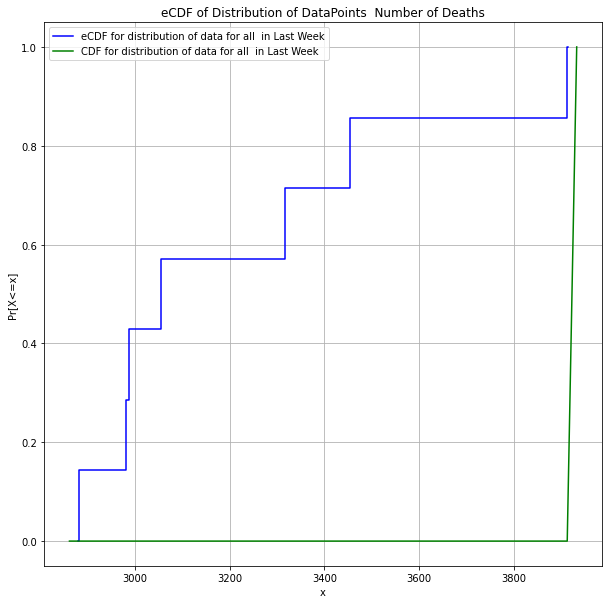

In [199]:
#Binomial distribution requires p -> MME for 3 part of data
## guess lambda for last week
from scipy.special import factorial
from scipy.special import comb
from scipy.stats import binom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def sigmaSquared(dataset):
  s=0;
  for i in range(len(dataset)):
    element=dataset[i] ** 2
    s+=element
  return s



def parametersMMEBionomial(numTrials, numSuccess):
  p=np.sum(numSuccess)/np.sum(numTrials)
  return p



def F_yBinomial(numTrials, numSuccess, p):
  FyArray=[]
  summ=0
  for i in range(len(numSuccess)):
    summ+=numSuccess[i]
    fy=binom.cdf(summ,numTrials,p)
    FyArray.append(fy)

  return FyArray
print("x",secondlastWeek_cases)

factor=float(1/7)
Fx_pos=Fx_posX(factor)
print("F +x",Fx_pos)

Fx_neg=Fx_negX(factor)
print("F -x",Fx_neg)

##deaths
pBinomial=parametersMMEBionomial(secondlastWeek_cases,secondlastWeek_deaths)
print("Deaths Binomial MME p:",pBinomial)

f_yBinomial=F_yBinomial(np.sum(lastWeek_cases),lastWeek_deaths ,pBinomial)
print("F_y ",f_yBinomial)
Fxpos_diff_Fy= [abs(Fx_pos[j] - f_yBinomial[j]) for j in range(len(Fx_pos)) ] 
print("F+x - Fy",Fxpos_diff_Fy)

Fxneg_diff_Fy=[abs(Fx_neg[j] - f_yBinomial[j]) for j in range(len(Fx_neg)) ] 
print("F-x - Fy",Fxneg_diff_Fy)



D__FxFy=(Fxpos_diff_Fy) +(Fxneg_diff_Fy)

D=max(D__FxFy)
print("Maximum value found D(Fx,Fy):",D)

if D < 0.05:
  print("We accept the KS test for 1-sample test: Daily deaths data vs Binomial Distribution ")
else:
  print("We reject the KS test for 1-sample test: Daily deaths data vs Binomial Distribution ")

print()
draw_plot(sorted(lastWeek_deaths),(f_yBinomial), "Last Week", " Number of Deaths")




#### Binomial Distribution : Number of cases

Cases Binomial MME  p: 0.45823007272786176
X [124100, 123818, 117500, 116859, 110916, 112228, 101458]
Fy [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999999999999999]
F+x - Fy [0.14, 0.29, 0.43, 0.57, 0.71, 0.86, 1.1102230246251565e-16]
F-x - Fy [0.0, 0.14, 0.29, 0.43, 0.57, 0.71, 0.1399999999999999]
Maximum values found D(Fx,Fy): 0.86
We reject the KS test for 1-sample test: Daily cases data vs Binomial Distribution 
Sample1: [50955, 54470, 54568, 56718, 57138, 59126, 59526]


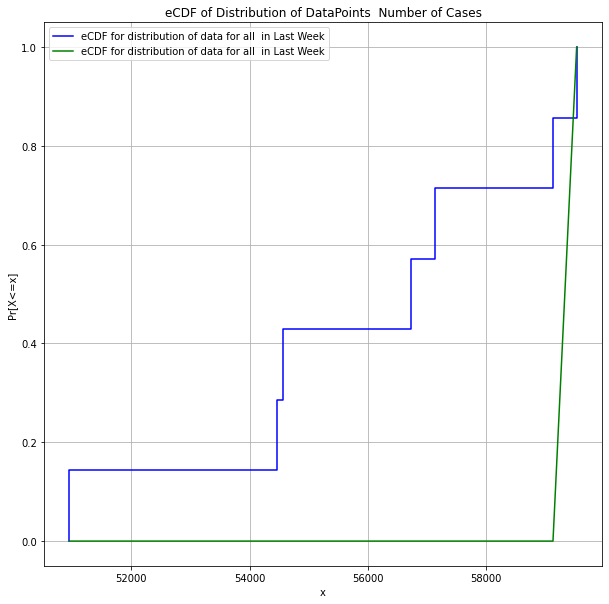

In [150]:

##cases
pBinomial=parametersMMEBionomial(secondlastWeek_testcases,secondlastWeek_cases)
print("Cases Binomial MME  p:",pBinomial)
print("X",lastWeek_testcases)
f_yBinomial=F_yBinomial(np.sum(lastWeek_testcases),sorted(lastWeek_cases),pBinomial)
print("Fy",f_yBinomial)
Fxpos_diff_Fy= [abs(Fx_pos[j] - f_yBinomial[j]) for j in range(len(Fx_pos)) ] 
print("F+x - Fy",Fxpos_diff_Fy)

Fxneg_diff_Fy=[abs(Fx_neg[j] - f_yBinomial[j]) for j in range(len(Fx_neg)) ] 
print("F-x - Fy",Fxneg_diff_Fy)

D__FxFy=(Fxpos_diff_Fy) +(Fxneg_diff_Fy)

D=max(D__FxFy)
print("Maximum values found D(Fx,Fy):",D)
if D < 0.05:
  print("We accept the KS test for 1-sample test: Daily cases data vs Binomial Distribution ")
else:
  print("We reject the KS test for 1-sample test: Daily cases data vs Binomial Distribution ")

draw_plot(sorted(lastWeek_cases),(f_yBinomial), "Last Week", " Number of Cases")



#### Conclusion
>For Number of Deaths:  

>> **Null Hypothesis:**  CDF Distribution of data for Number of Deaths is equivalent to the CDF Binominal Distribution
 
>> **We reject this Hypothesis.**


>For Number of Cases:   

>> **Null Hypothesis:** CDF Distribution of data for Number of Cases is equivalent to the CDF Binomial Distribution

>> **We reject this Hypothesis.**

> Hence,Given data does not follow the Binominal Distribution



#### 2-Sample KS test for second last and last week

>For Number of Deaths:

>> **Null Hypothesis:** CDF Distribution of data for Number of Deaths for 2nd Last week is equivalent to the CDF distribution of Last week


>For Number of Cases:

>>**Null Hypothesis: **CDF Distribution of data for Number of Cases for 2nd last Week is equivalent to the CDF Distribution of Last week

Here we check if both the week's data follow the same distribution


In [0]:
import bisect
from scipy.stats import ks_2samp

def sort_array(sample):
    return np.sort(sample)
def kolgomorov_smirnov_test(sample1, sample2):
    s1 = sorted((sample1))
    s2 = sorted((sample2))
    sample1_index = 0
    sample2_index = 0
    max_distance = 0.0
    cdf1 = 0.0
    cdf2 = 0.0
    p1 = 0
    p2 = 0
    q1 = 0.0
    q2 = 0.0
    while (sample1_index < len(s1) and sample2_index < len(s2)):        
        val1 = s1[sample1_index]
        val2 = s2[sample2_index]     
        if val1 <= val2:
            cdf1 = (sample1_index + 1)/len(s1)
        if val2 <= val1:
            cdf2 = (sample2_index + 1)/len(s2)
        dist = abs(cdf2 - cdf1)
        if dist > max_distance:
            max_distance = dist
            q1 = cdf1
            q2 = cdf2
            if val1 <= val2 and (sample1_index + 1) < len(s1):
              p1 = sample1_index + 1
            if val2 <= val1 and (sample2_index+1) < len(s2):
              p2 = sample2_index + 1
        if val1 <= val2:
          sample1_index = sample1_index + 1
        if val2 <= val1:
          sample2_index = sample2_index + 1
    
    #print(max_distance,s1[p1],s2[p2],q1,q2,p1,p2)
    return max_distance,s1[p1],s2[p2],q1,q2


def draw_plot2(sample1, sample2, week1, week2,sample2maxDist_pt2,sample1maxDist_p1,cdf_2,cdf_1,dif,dataText):
  print("Sample1:",sample1)
  print("Sample2:",sample2)
  n1 = len(sample1)
  Srt1 = sorted(sample1)
  delta = 1
  X1 = [min(Srt1)-delta]
  Y1 = [0]
  for i in range(0,n1):
    X1 = X1 + [Srt1[i], Srt1[i]]
    Y1 = Y1 + [Y1[len(Y1)-1], Y1[len(Y1)-1]+(1/n1)]
  X1 = X1 + [max(Srt1)+delta]
  Y1 = Y1 + [1]
  
  n2 = len(sample2)
  Srt2 = sorted(sample2)
  delta = 1
  X2 = [min(Srt2)-delta]
  Y2 = [0]
  for i in range(0,n2):
    X2 = X2 + [Srt2[i], Srt2[i]]
    Y2 = Y2 + [Y2[len(Y2)-1], Y2[len(Y2)-1]+(1/n2)]
  X2 = X2 + [max(Srt2)+delta]
  Y2 = Y2 + [1]
  fig = plt.figure('eCDF', figsize=(20,20))
  # plt.figure()
  p1 = X1[bisect.bisect_left(Srt1,sample1maxDist_p1)]
  p2 = X2[bisect.bisect_right(Srt2,sample2maxDist_pt2)]
  
  plt.plot(X1, Y1 ,color='blue',label='eCDF for distribution of data for all  in '+ week1)
  plt.plot(X2, Y2,color='black', label='eCDF for distribution of data for all  in '+ week2)
  plt.plot([sample2maxDist_pt2, sample2maxDist_pt2], [cdf_1,cdf_2], color='green', linestyle='-', linewidth=2, label = "Max Difference Line with length of "+str(dif))
  plt.xlabel('x')
  plt.ylabel('Pr[X<=x]')
  plt.title('eCDF of Distribution of DataPoints '+ dataText)
  plt.legend(loc="upper left")
  plt.grid()
  plt.show()


def check2sampleKSTest(maxDist, dataText):
  print("MaxDistance",maxDist)

  if maxDistance < 0.05:
    print("We accept the KS test for 2-sample test: Second last week data vs last week data for ", dataText)
  else:
    print("We reject the KS test for 2-sample test: Second last week data vs last week data for ",dataText)

def KSTest2Sample(data1,data2,text):
  maxDistance,sample1_maxDist_p1,sample2_maxDist_p2,cdf1,cdf2 = kolgomorov_smirnov_test(data1,data2)
  check2sampleKSTest(maxDistance, text)
  draw_plot2(data1,data2,'2nd Last Week','Last Week',sample2_maxDist_p2,sample1_maxDist_p1,cdf2,cdf1,maxDistance,text)



MaxDistance 0.8571428571428571
We reject the KS test for 2-sample test: Second last week data vs last week data for  Number of Deaths
Sample1: [3626, 3755, 4089, 4116, 4155, 4341, 4460]
Sample2: [2882, 2981, 2988, 3056, 3316, 3454, 3912]


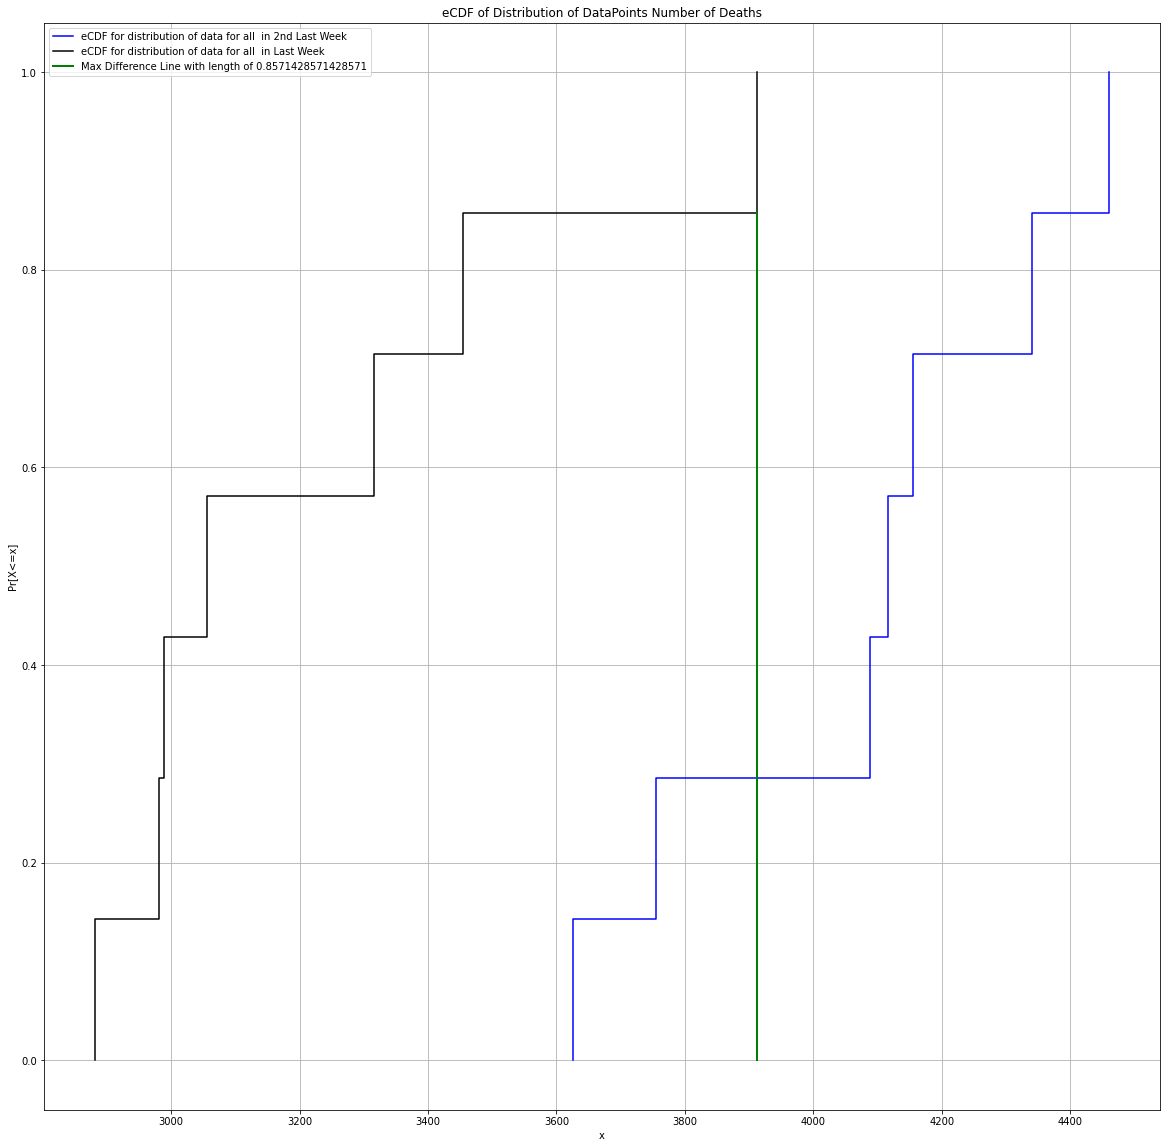

In [193]:


##KS test for Number of Deaths
KSTest2Sample(sorted(secondlastWeek_deaths),sorted(lastWeek_deaths),"Number of Deaths")




1.0 61664 59526 0.0 1.0 0 6
MaxDistance 1.0
We reject the KS test for 2-sample test: Second last week data vs last week data for  Number of Daily Cases
Sample1: [61664, 62053, 63578, 64691, 64875, 67015, 68760]
Sample2: [50955, 54470, 54568, 56718, 57138, 59126, 59526]


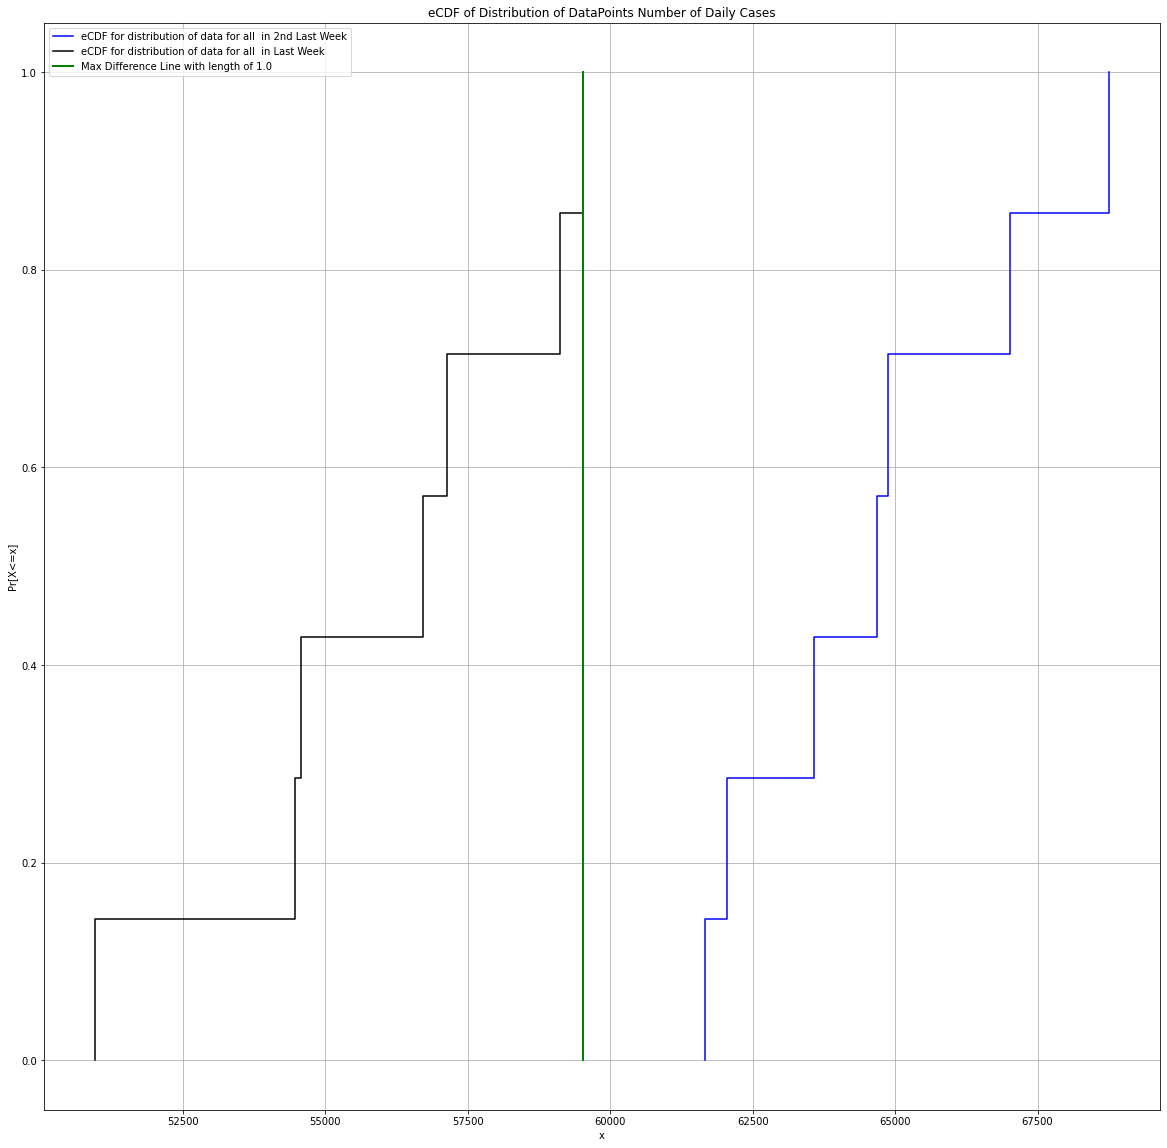

In [175]:
##KS test for Number of Cases

KSTest2Sample(sorted(secondlastWeek_cases),sorted(lastWeek_cases),"Number of Daily Cases")


#### Conclusion:
>For Number of Deaths:

>> **Null Hypothesis**: CDF Distribution of data for Number of Deaths for 2nd Last week is equivalent to the CDF distribution of Last week


>For Number of Cases:

>>**Null Hypothesis**: CDF Distribution of data for Number of Cases for 2nd last Week is equivalent to the CDF Distribution of Last week

Here we checked if both the weeks' data follow the same distribution. Hence we conclude that the two samples do not follow the same distribution

**We reject the Null Hypothesis** that both the datasets follow the same distribution


#### 3.3.2 Permutation Test



>For Number of Deaths:

>> **Null Hypothesis:** Data for Number of Deaths for 2nd Last week is equivalent to the Data of Last week


>For Number of Cases:

>>**Null Hypothesis:** Data for Number of Cases for 2nd last Week is equivalent to the Data of Last week

Here we have perform the permutation-test to check if the two datasets are equivalent

In [189]:
def t_value(data1, data2):
  return abs(np.average(data1) - np.average(data2))

def calculate_p_value(table_data1,table_data2,n = 50000):
  nparr1 = (table_data1)#create_numpy_arr
  nparr2 = (table_data2)
  size1 = np.size(nparr1)
  size2 = np.size(nparr2)
  print(table_data1,table_data2)
  t_observed = t_value(nparr1, nparr2)
  
  total_count_of_indicators = 0
  arr = np.concatenate((nparr1,nparr2))
  for i in range(0,n):
    arr = np.random.permutation(arr)
    part1, part2 = arr[:size1], arr[size1:]
    t_perm = t_value(part1, part2)
    if(t_perm > t_observed):
      total_count_of_indicators = total_count_of_indicators + 1
  return total_count_of_indicators/n

def accept_or_reject(p_val, threshold):
  if(p_val <= threshold):
    return "rejected"
  else:
    return "accepted"

def accept_or_reject_ks(p_val, threshold):
  if(p_val > threshold):
    return "rejected"
  else:
    return "accepted"

p_val1 = calculate_p_value(sorted(lastWeek_deaths),sorted(secondlastWeek_deaths),50000)
print("The p-value for distribution of points with 7 permutations is : " + str(p_val1) +". The threshold is 0.05. Hence, this hypothesis is "+accept_or_reject(p_val1,0.05))


[2882, 2981, 2988, 3056, 3316, 3454, 3912] [3626, 3755, 4089, 4116, 4155, 4341, 4460]
The p-value for distribution of points with 7 permutations is : 0.00106. The threshold is 0.05. Hence, this hypothesis is rejected


#### Conclusion

>For Number of Deaths:

>> Null Hypothesis: Data for Number of Deaths for 2nd Last week is equivalent to the Data of Last week


>For Number of Cases:

>>Null Hypothesis: Data for Number of Cases for 2nd last Week is equivalent to the Data of Last week

Here we have performed the permutation-test and conclude that the two datasets are very different from each other since the Tobserve for the data is large.

**We reject the null hypothesis** that two datsets are equivalent



### 3.4 Pearson correlation for #deaths and Total Traded Stocks,  #cases and Total Traded Stocks


Report the Pearson correlation value for #deaths and your X dataset, and also for #cases and your X dataset over one month of data. Use the most relevant column in X to compare against the covid numbers.

In [0]:
import math
def p_coeff(a,b):

    ab_n1 = 0 
    ab_d1 = 0 
    ab_d2 = 0

    mean_a = sum(a)/len(a)
    mean_b = sum(b)/len(b)
    for i, j in zip(a,b):
        ab_n1 += (i- mean_a) * (j- mean_b)
        ab_d1 += (i- mean_a) * (i- mean_a)
        ab_d2 += (j- mean_b) * (j- mean_b)
    ab = ab_n1 / (math.sqrt(ab_d1) * math.sqrt(ab_d2))
    return ab

#### Calculating Total Traded Stocks for the Day

In [0]:
comb_df['UberTradedStocks']= comb_df['UberVolume']* comb_df['UberClosingPrice']
comb_df['LyftTradedStocks']= comb_df['LyftVolume'] * comb_df['LyftClosingPrice']

#### 3.4.1 Pearson correlation for #deaths and Total Traded Stocks

In [0]:
corr= p_coeff(comb_df['cumdeath'], comb_df['UberTradedStocks'])
print('\033[1m' + 'Pearsons correlation of #deaths and Stock Price of Uber: %.3f' % corr)

corr = p_coeff(comb_df['cumdeath'], comb_df['LyftTradedStocks'])
print('\033[1m' + 'Pearsons correlation of #deaths and Stock Price of Lyft: %.3f' % corr)


Pearsons correlation of #deaths and Stock Price of Uber: -0.723
Pearsons correlation of #deaths and Stock Price of Lyft: -0.406


######  Inference: We can observe a high negative linear correlation between stock prices of Uber/Lyft v/s the Deaths, this means that increase in #deaths day on day has adversely affected ride sharing company with less people moving out

#### 3.4.2 Pearson correlation for #cases and Stock Price

In [0]:
corr= p_coeff(comb_df['cumpositive'],  comb_df['UberTradedStocks'])
print('\033[1m' + 'Pearsons correlation of #Confirmed Cases and Stock Price of Uber: %.3f' % corr)

corr= p_coeff(comb_df['cumpositive'], comb_df['LyftTradedStocks'])
print('\033[1m' + 'Pearsons correlation of #Confirmed Cases and Stock Price of Lyft: %.3f' % corr)


Pearsons correlation of #Confirmed Cases and Stock Price of Uber: -0.783
Pearsons correlation of #Confirmed Cases and Stock Price of Lyft: -0.478


######  Inference: We can observe a high negative linear correlation between stock prices of Uber/Lyft v/s the #Confirm cases, this means that increase in #Confim cases day on day has brought the city to a halt and ride sharing company stocks are going down as less and less people are moving out

### 3.5 Posterior Distributions for daily deaths parameter estimator 

Assume the daily deaths are Poisson distributed with parameter lambda. Assume an Exponential prior on lambda. Use first week’s data to obtain the posterior for lambda via Bayesian inference. Now, use second week’s data to obtain the new posterior, using prior as posterior after week 1. Repeat till the end of week 4. Plot all posterior distributions on one graph. Report the MAP for all posteriors.

#### 3.5.1 First week to Second week

#### 3.5.2 Second week to third week

#### 3.5.3 Third week to fourth week

#### 3.5.4 Plot all posterior distributions on one graph

#### 3.5.5 Report the MAP for all posteriors

## Part 4: Creative Inferences (30%)

Propose three new inferences for your dataset and solve them using tools learned in class. You will be graded on creativity/practicality of your inferences. For each inference you propose, provide a paragraph of text to explain why this inference is practical and useful. Also comment on the results of your inference, as appropriate. See “Sample inferences section below for ideas. Only use tools/tests learned in class. This will be 30% of the project grade. 

### Hypothesis1: Performing Chi-Square test to show due to Uber Lyft being functional Covid Spread Quickly and once they were shut spread went down

Using Chi-square independence test to check if Uber Stock Prices impacted COVID19 cases

#### Step 1: Define the Hypothesis

###### For this we will be creating two lables for COVID19 changes in Confirmed Cases ("Positive_pctChange") as postive and negative , and similarly changes in Closing price for Uber ("Uber_pctChange") as positive and negative

For our example, the hypothesis are:
H0: The Change in Confirmed Cases(Positive_pctChange) and changes in Closing price for Uber ("Uber_pctChange") are independent (which means they are not associated)
H1: Change in Confirmed Cases and changes in Closing price for Uber are not independent (which means they are associated)

In [0]:
var1= 'UberClosingPrice'
var2= 'cumpositive'

comb_df['Uber_pctChange'] = comb_df[var1].pct_change(periods=1)
comb_df['Confirmed_pctChange'] = comb_df[var2].pct_change(periods=1)
# comb_df['Lyft_pctChange'] = comb_df['LyftClosingPrice'].pct_change(periods=1)
comb_df=comb_df.iloc[1:]

comb_df['Uber_Slope'] = comb_df['Uber_pctChange'].pct_change(periods=1)
comb_df['Confirmed_Slope'] = comb_df['Confirmed_pctChange'].pct_change(periods=1)
# comb_df['Lyft_Slope'] = comb_df['Lyft_pctChange'].pct_change(periods=1)
comb_df=comb_df.iloc[1:]

Crating Lables for Changes in Confirm Cases and Uber's Closing Price Day On Day

In [0]:
comb_df['Confirmed_Label']= np.where(comb_df['Confirmed_Slope'] >= 0, 'Positive', 'Negative')
comb_df['Uber_Label']= np.where(comb_df['Uber_Slope'] >= 0, 'Positive', 'Negative')
# comb_df['Lyft_Label']= np.where(comb_df['Lyft_Slope'] >= 0, 'Positive', 'Negative')


In [0]:
comb_df.iloc[:,20:28].head(2)

,Uber_Slope,Confirmed_Slope,Confirmed_Label,Uber_Label
40,-4.318268,0.650000,Positive,Negative
39,0.468009,-0.583333,Negative,Positive


#### Step2: Choose a significance Level

For the null hypothesis to be rejected the p-value should be less than the significance level.
Lower α values are generally preferred which may be in the range of 0.01 to 0.10.
We choose α = 0.05

#### Step3: Create Contingency table

In [0]:
Q=pd.crosstab(comb_df['Confirmed_Label'], comb_df['Uber_Label'], rownames=['Confirmed_Label'], colnames=['Uber_Label'])
print(Q)

Q_table = comb_df.groupby(['Confirmed_Label','Uber_Label'])['date'].count()
Q_table = Q_table.reset_index()
Q_table.columns = ['Confirmed_Label','Uber_Label','TotalDays']

Uber_Label       Negative  Positive
Confirmed_Label                    
Negative               14         5
Positive               13         6


#### Step4: Calculate Expected Frequency

In [0]:
comb_df.shape
total=  Q_table['TotalDays'].sum()

per_cp= round(Q_table[(Q_table['Confirmed_Label']== 'Positive')].TotalDays.sum()/total,2)
per_up= round(Q_table[(Q_table['Uber_Label']== 'Positive')].TotalDays.sum()/total,2)

ob_cp_up= Q_table[(Q_table['Confirmed_Label']== 'Positive') & (Q_table['Uber_Label'] =='Positive')].TotalDays.sum()
ob_cp_un= Q_table[(Q_table['Confirmed_Label']== 'Positive') & (Q_table['Uber_Label'] =='Negative')].TotalDays.sum()
ob_cn_up= Q_table[(Q_table['Confirmed_Label']== 'Negative') & (Q_table['Uber_Label'] =='Positive')].TotalDays.sum()
ob_cn_un= Q_table[(Q_table['Confirmed_Label']== 'Negative') & (Q_table['Uber_Label'] =='Negative')].TotalDays.sum()

ex_cp_up= per_cp*per_up*total
ex_cp_un= per_cp*(1-per_up)*total
ex_cn_up= (1-per_cp)*per_up*total
ex_cn_un= (1-per_cp)*(1-per_up)*total


print(total, per_cp, per_up, ob_cp_up, ob_cp_un, ob_cn_up, ob_cn_un, ex_cp_up, ex_cp_un, ex_cn_up, ex_cn_un)

38 0.5 0.29 6 13 5 14 5.51 13.489999999999998 5.51 13.489999999999998


#### Step5: Calculate Chi-Square Statistic

In [0]:
def diff_sq(Obs, Exp):
    return ((Obs-Exp)**2)/Exp

In [0]:
Q= diff_sq(ob_cp_up, ex_cp_up) + diff_sq(ob_cp_un, ex_cp_un) + diff_sq(ob_cn_up, ex_cn_up) + diff_sq(ob_cn_un, ex_cn_un)

print('\033[1m' + 'Q statistics value: ' + str(Q))

Q statistics value: 0.12785971728739043


#### Step6: Calculate degrees of freedom

In [0]:
total_rows=2
total_cols=2
dfr = (total_rows - 1) * (total_cols - 1)
print('\033[1m' + 'degree of freedom: ' + str(dfr))

degree of freedom: 1


#### Step7: Find p-value

calculate the p-value from this website: https://www.socscistatistics.com/pvalues/chidistribution.aspx

In [0]:
pval=.720724

In [0]:
# select significance value
alpha = 0.05
# Determine whether to reject or keep your null hypothesis
print('\033[1m' +  'significance=%.3f, p=%.3f' % (alpha, pval))
if pval <= alpha:
    print('\033[1m' +  'COVID spread due to Uber being functinal are associated (reject H0)')
else:
    print('\033[1m' +  'COVID spread due to Uber being functinal are not associated(fail to reject H0)')

significance=0.050, p=0.721
COVID spread due to Uber being functinal are not associated(fail to reject H0)


#### Inference1: Below are the inference for H1

### Hypothesis2: Using K-S Test to show that COVID Positive Cases fluctuation and Uber Stock fluctuation follows the Same distribution

#### Inference2: Below are the inference for H2

### Inference3: Linear regression to find the impact on Stock Prices of Uber +Lyft because of the severity of covid19  duration, feature as (+ve -ve death), fetching predicted covid values of (+ve -ve death) from  Part 3.1